Меня несколько заинтересовала тема анализа тональности (Sentiment Analysis), поэтому я хотела бы посмотреть, как с этой задачей справляются различные штуки.

# Датасет

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/women-clothing-accessories.3-class.balanced.csv", sep='\t')
df['sentiment'] = df.sentiment.map({'positive': 1, 'negative': -1, 'neautral': 0})  # мне так привычнее
df

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,-1
1,"Товар отдали другому человеку, я не получила п...",-1
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",-1
3,"товар не пришел, продавец продлил защиту без м...",-1
4,"Кофточка голая синтетика, носить не возможно.",-1
...,...,...
89995,сделано достаточно хорошо. на ткани сделан рис...,1
89996,Накидка шикарная. Спасибо большое провдо линяе...,1
89997,спасибо большое ) продовца рекомендую.. заказа...,1
89998,Очень довольна заказом! Меньше месяца в РБ. К...,1


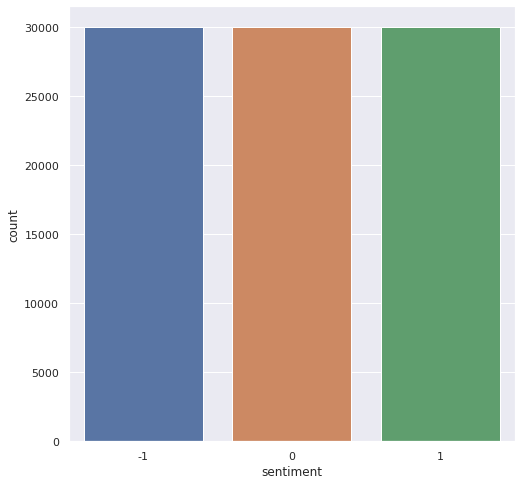

In [ ]:
fig = plt.figure(figsize=(8, 8))
sns.countplot(data=df, x='sentiment')  # датасет сбалансированный, не может не радовать

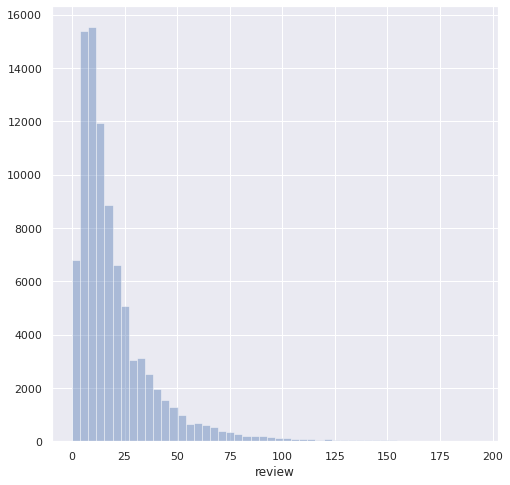

In [ ]:
fig = plt.figure(figsize=(8, 8))
sns.distplot(df.review.apply(lambda text: len(text.split())), kde=False)  # логнормальное рапсределение

# Предобработка

In [ ]:
for review in df.review.sample(10):
    print(review, end='\n\n')

Кофта тонкая(просвечивается), не тёплая, низ широкий,рукава коротковаты, только на пухленьких. Шло почти два месяца, трек не отслеживался. Такое ощущение, что ворот кофты, чуть ли не из бумаги, боюсь после первой стирки придётся выкинуть.

Отлично! Материал качественный, не просвечивает.  На 93- 72- 98 отлично. Товар отслеживался, продавца рекомендую)

Джинсы прикольные,хорошо тянутся,но мне они велики! Брала по таблице,бедра у меня 104  

Оценила на 3 потому что не хлопок. Чистая синтетика, Очень тонкий трикотаж, с запахом. Цвет немного отличается, но это не важно. Шорты короче чем на фото, сшиты немного странно, тянет в ногах. В магазине бы такое качество я бы не взяла. Спать будет не очень комфортно, но для дома такой костюм хороший. Качество строчек так себе.

Очень короткая, как на куклу

швы расходятся, прошито плохо. открыл спор и продавец вернул деньги

Класс толстовка,мягкая,по размеру подошло,продавец супер.

рубашки не пришли. спасибо продавцу за быстрый возврат денег.

The 

In [ ]:
%%capture
!pip install langdetect  # было бы неплохо узнать, тексты на каких языках у нас имеются

In [ ]:
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0
languages = []
for review in df.review:
  try:
    languages.append(detect(review))
  except:
    languages.append('?')

In [ ]:
df['language'] = languages
df.sample(3)

,review,sentiment,language
70161,Продаю в магазине. Боюсь что размер М-это разм...,1,ru
7691,юбка не пришла. деньги не вернули,-1,ru
37293,"Доставка быстрая в течении месяца,но заказом н...",0,ru


In [ ]:
print(*list(zip(np.unique(languages, return_counts=True)[0], np.unique(languages, return_counts=True)[1])))  # преимущественно русский

('?', 144) ('af', 27) ('bg', 1806) ('ca', 20) ('cs', 1) ('cy', 1) ('da', 8) ('de', 8) ('en', 917) ('es', 18) ('et', 7) ('fi', 3) ('fr', 14) ('hr', 5) ('id', 7) ('it', 5) ('lt', 1) ('lv', 1) ('mk', 1643) ('nl', 3) ('no', 7) ('pl', 5) ('pt', 17) ('ro', 11) ('ru', 84749) ('sk', 14) ('sl', 3) ('so', 17) ('sq', 2) ('sv', 3) ('tl', 5) ('tr', 4) ('uk', 517) ('vi', 4) ('zh-cn', 3)


In [ ]:
df_ru = df[df.language == 'ru'].drop(columns='language').reset_index(drop=True)  # не русскоязычных отзывов слишком мало, чтобы строить модели с ними

In [ ]:
import re

def remove_matched_brackets(text):
  prev_state = text
  new_state = re.sub(r'(\(([^\(\)]*)\))', r'\2', prev_state)
  while new_state != prev_state:
    prev_state, new_state = new_state, re.sub(r'(\(([^\(\)]*)\))', r'\2', prev_state)
  return new_state

def simple_preprocessing(text):
  step1 = re.sub(r'[^а-яё!?\(\)]', ' ', text.lower())  # избавимся от лишних символов
  step2 = remove_matched_brackets(step1)  # уберем закрытые скобки (не закрытые - это смайлики)
  step3 = re.sub(r'(.)\1{3,}', r'\1' * 3, step2)  # заменим все слишком длинные последовательности на такие же длины 3
  step4 = re.sub(r'(\(+|\)+|!+|\?+)', r' \1 ', step3)  # отделим скобочки и знаки пунктуации от слов (токенизации ради)
  step5 = re.sub(r' +', ' ', step4)  # приведем все пробелы к нормальному виду
  return step5.strip()

In [ ]:
text = """Рубашка пришла!!!! 52- 54.Сверху смотрится неплохо. (Плечи очень красивые) 
Но на спине висит мешком. придётся ушивать или  делать вид, что так сейчас модно. 
Материал голимая синтетика,100%,к телу очень не приятно. Купила, т.к. начиталась 
отзывов блоггеров :((((Им,наверное, платят за красивые и хорошие отзывы?"""

simple_preprocessing(text)  # проверим, всё ли корректно работает

'рубашка пришла !!! сверху смотрится неплохо плечи очень красивые но на спине висит мешком придётся ушивать или делать вид что так сейчас модно материал голимая синтетика к телу очень не приятно купила т к начиталась отзывов блоггеров ((( им наверное платят за красивые и хорошие отзывы ?'

In [ ]:
df_ru['preprocessed'] = df_ru.review.apply(simple_preprocessing)
df_ru.sample(3)

,review,sentiment,preprocessed
47742,Кружева порваны!,0,кружева порваны !
21949,"посылку так и не получила, хотя продавец посто...",-1,посылку так и не получила хотя продавец постоя...
74224,"его нужно примерить,чтобы понять угадали с раз...",1,его нужно примерить чтобы понять угадали с раз...


Интересно, будут ли хорошие отзывы короче плохих?

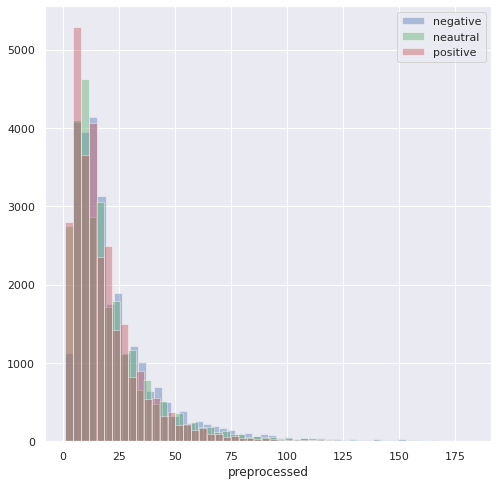

In [ ]:
fig = plt.figure(figsize=(8, 8))  # не будут, а так хотелось...
sns.distplot(df_ru[df_ru.sentiment == -1].preprocessed.apply(lambda text: len(text.split())), kde=False, color='b', label='negative')
sns.distplot(df_ru[df_ru.sentiment == 0].preprocessed.apply(lambda text: len(text.split())), kde=False, color='g', label='neautral')
sns.distplot(df_ru[df_ru.sentiment == 1].preprocessed.apply(lambda text: len(text.split())), kde=False, color='r', label='positive')
plt.legend()

Мне кажется, если удалить стоп-слова, станет хуже, потому что стандартные стоп-слова для этой задачи точно не подойдут, а на составление списка можно потратить очень и очень много времени. Лемматизация и стемминг тоже не кажутся хорошим занятием в силу специфики текстов (много сленга и опечаток). Да и word2vec с подобным спосбом обработанными текстами не очень хорошо себя показывает.

In [ ]:
%%capture
!sudo apt-get install swig
!sudo pip install jamspell

In [ ]:
%%capture
!wget https://github.com/bakwc/JamSpell-models/raw/master/ru.tar.gz
!tar -xvf ru.tar.gz

In [ ]:
import jamspell  # опечатки было бы неплохо исправить
# инфо про библиотку тут: https://habr.com/ru/post/346618/
# а про установку тут: https://colab.research.google.com/drive/1aFk8-7nq3oAp402jjLGLpEb2Nzq210Eo#scrollTo=5ZSmLdaRX-FX

corrector = jamspell.TSpellCorrector()
assert corrector.LoadLangModel('ru_small.bin')

In [ ]:
df_ru['preprocessed'] = df_ru.preprocessed.apply(corrector.FixFragment)

In [ ]:
 # я ушла пить чай, это чтобы работа не пропала :)
df_ru.to_csv('/content/drive/MyDrive/Colab Notebooks/df_ru.csv', sep='\t', columns=['preprocessed', 'sentiment'], index=False) 

# Анализ тональности

In [ ]:
df_ru = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df_ru.csv", sep='\t')
df_ru.sample(3)

,preprocessed,sentiment
52528,размер неправильный не понравился заказ,0
16218,нихера нет поддержки защиты от недобросовестно...,-1
11537,очень плохое качество нет этикетки,-1


## Bag-of-words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


def report(test, pred):  # визуализация матрицы ошибок и вывод метрик
  print(classification_report(test, pred))
  cm = confusion_matrix(test, pred)
  df_cm = pd.DataFrame(cm, index=["negative", "neautral", "positive"],
                       columns=["negative", "neautral", "positive"])
  plt.figure(figsize = (7, 5))
  plt.title("Confusion matrix")
  sns.heatmap(df_cm, annot=True, cmap="Greens", fmt='g')
  plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_ru.preprocessed, df_ru.sentiment, train_size = 0.7, random_state=42)

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 3))  # bag-of-words
xcv_train_test = count_vectorizer.fit(x_train.append(x_test))
xcv_train = count_vectorizer.transform(x_train)
xcv_test = count_vectorizer.transform(x_test)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # tf-idf
xTfidf_train_test = tfidf_vectorizer.fit(x_train.append(x_test))
xTfidf_train = tfidf_vectorizer.transform(x_train)
xTfidf_test = tfidf_vectorizer.transform(x_test)

              precision    recall  f1-score   support

          -1       0.72      0.70      0.71      8335
           0       0.63      0.67      0.65      8513
           1       0.88      0.85      0.86      8577

    accuracy                           0.74     25425
   macro avg       0.74      0.74      0.74     25425
weighted avg       0.74      0.74      0.74     25425



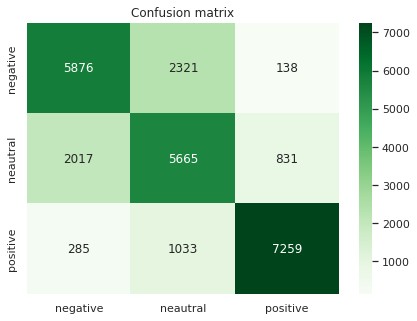

In [ ]:
from sklearn.naive_bayes import MultinomialNB  

clf = MultinomialNB(alpha=2)  # наивный байес
clf.fit(xcv_train, y_train)
ycv_pred = clf.predict(xcv_test)
report(y_test, ycv_pred)

              precision    recall  f1-score   support

          -1       0.73      0.68      0.71      8335
           0       0.62      0.68      0.65      8513
           1       0.87      0.86      0.86      8577

    accuracy                           0.74     25425
   macro avg       0.74      0.74      0.74     25425
weighted avg       0.74      0.74      0.74     25425



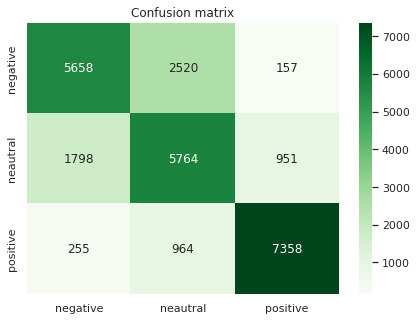

In [ ]:
clf = MultinomialNB(alpha=0.5)
clf.fit(xTfidf_train, y_train)
ytf_pred = clf.predict(xTfidf_test)
report(y_test, ytf_pred)

              precision    recall  f1-score   support

          -1       0.71      0.67      0.69      8335
           0       0.60      0.63      0.62      8513
           1       0.85      0.85      0.85      8577

    accuracy                           0.72     25425
   macro avg       0.72      0.72      0.72     25425
weighted avg       0.72      0.72      0.72     25425



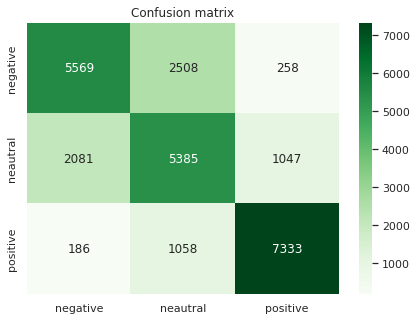

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC()  # метод опорных векторов
clf.fit(xcv_train, y_train)
ycv_pred = clf.predict(xcv_test)
report(y_test, ycv_pred)

              precision    recall  f1-score   support

          -1       0.73      0.71      0.72      8335
           0       0.63      0.66      0.65      8513
           1       0.87      0.86      0.87      8577

    accuracy                           0.74     25425
   macro avg       0.75      0.74      0.74     25425
weighted avg       0.75      0.74      0.74     25425



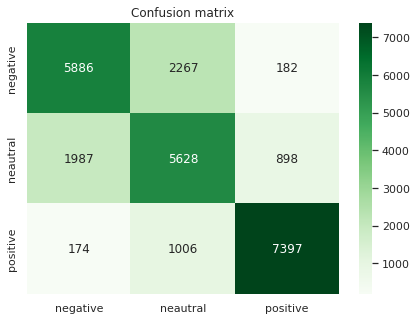

In [ ]:
clf = LinearSVC()
clf.fit(xTfidf_train, y_train)
ytf_pred = clf.predict(xTfidf_test)
report(y_test, ytf_pred)

              precision    recall  f1-score   support

          -1       0.70      0.69      0.70      8335
           0       0.61      0.62      0.62      8513
           1       0.85      0.85      0.85      8577

    accuracy                           0.72     25425
   macro avg       0.72      0.72      0.72     25425
weighted avg       0.72      0.72      0.72     25425



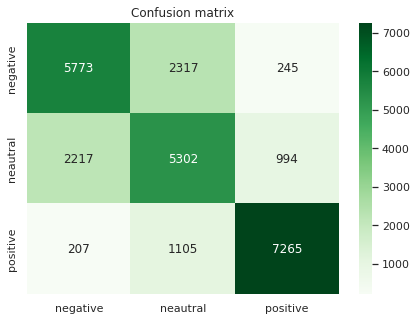

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1e5)  # логистическая регрессия
clf.fit(xcv_train, y_train)
ycv_pred = clf.predict(xcv_test)
report(y_test, ycv_pred)

              precision    recall  f1-score   support

          -1       0.70      0.71      0.70      8335
           0       0.62      0.61      0.62      8513
           1       0.86      0.86      0.86      8577

    accuracy                           0.73     25425
   macro avg       0.73      0.73      0.73     25425
weighted avg       0.73      0.73      0.73     25425



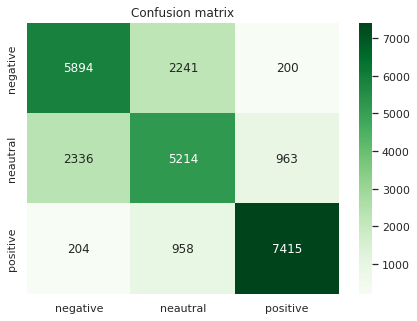

In [ ]:
clf = LogisticRegression(C=1e5)
clf.fit(xTfidf_train, y_train)
ytf_pred = clf.predict(xTfidf_test)
report(y_test, ytf_pred)

Тексты короткие, поэтому TF-IDF не дает существенного прироста качества по сравнению с простым BOW. 

Из моделей лучше всего себя показал метод опорных векторов.

Все классификаторы мешают негативные и нейтральные отзывы, а также хорошо отличают положительные.

Попробуем лемматизировать тексты и посмотреть, станет ли лучше.

In [ ]:
%%capture
!pip install pymystem3==0.1.10  # в отличие от pymorphy2, поддерживает контекстную лемматизацию
# определенная версия по причине некоторой несовместимости с колабом

In [ ]:
from pymystem3 import Mystem

m = Mystem()

def lemmatize(text):
    lemmas = m.lemmatize(text)
    return "".join(lemmas).strip()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


In [ ]:
lemmatize("рассвет похож на расстрел после которого снова воскрес")  # вполне приемлемо работает

'рассвет похожий на расстрел после который снова воскресать'

In [ ]:
df_ru['lemmatized'] = df_ru.preprocessed.map(lambda text: lemmatize(text))
df_ru.sample(3)

,preprocessed,sentiment,lemmatized
69739,заказала второй раз качество хорошее носки и п...,1,заказывать второй раз качество хороший носок и...
55044,на свой размер заказала он оказался на столько...,0,на свой размер заказывать он оказываться на ст...
84038,немного велики штаны размера на рост и кг но с...,1,немного большой штаны размер на рост и кг но с...


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_ru.lemmatized, df_ru.sentiment, train_size = 0.7, random_state=42)

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 3))  # bag-of-words
xcv_train_test = count_vectorizer.fit(x_train.append(x_test))
xcv_train = count_vectorizer.transform(x_train)
xcv_test = count_vectorizer.transform(x_test)

              precision    recall  f1-score   support

          -1       0.72      0.70      0.71      8335
           0       0.63      0.67      0.65      8513
           1       0.89      0.84      0.86      8577

    accuracy                           0.74     25425
   macro avg       0.74      0.74      0.74     25425
weighted avg       0.74      0.74      0.74     25425



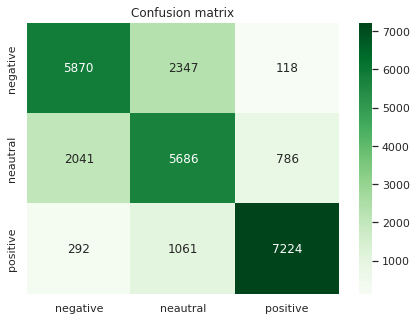

In [ ]:
clf = MultinomialNB(alpha=2) 
clf.fit(xcv_train, y_train)
ycv_pred = clf.predict(xcv_test)
report(y_test, ycv_pred)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # tf-idf
xTfidf_train_test = tfidf_vectorizer.fit(x_train.append(x_test))
xTfidf_train = tfidf_vectorizer.transform(x_train)
xTfidf_test = tfidf_vectorizer.transform(x_test)

              precision    recall  f1-score   support

          -1       0.72      0.71      0.72      8335
           0       0.63      0.65      0.64      8513
           1       0.87      0.86      0.87      8577

    accuracy                           0.74     25425
   macro avg       0.74      0.74      0.74     25425
weighted avg       0.74      0.74      0.74     25425



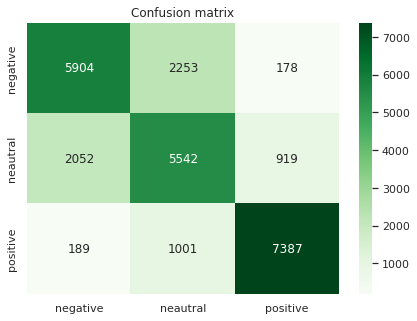

In [ ]:
clf = LinearSVC()
clf.fit(xTfidf_train, y_train)
ytf_pred = clf.predict(xTfidf_test)
report(y_test, ytf_pred)

Лучше не стало. Хуже тоже не стало. Вывод: в данной задаче при использовании Байеса и метода опорных векторов лемматизация никак не влияет на качество.

## Word2vec

In [ ]:
import gensim
from gensim.models import word2vec, Word2Vec

In [ ]:
def get_123grams(phrase):
    unigrams = list(phrase.split())
    bigrams = [' '.join(list(item)) for item in list(zip([None] + unigrams, unigrams))[1:]]
    trigrams = list(map(lambda item: ' '.join(item), list(zip([None, None] + bigrams, unigrams))[2:]))
    return unigrams + bigrams + trigrams

In [ ]:
df_ru['n-gramms'] = df_ru.preprocessed.map(lambda text: get_123grams(text))
df_ru.sample(3)

,preprocessed,sentiment,lemmatized,n-gramms
8650,товар так и не пришёл заказывали в начале сент...,-1,товар так и не приходить заказывать в начало с...,"[товар, так, и, не, пришёл, заказывали, в, нач..."
25555,трек не отслеживается ((( продлевал защиту три...,-1,трек не отслеживаться ((( продлевать защита тр...,"[трек, не, отслеживается, (((, продлевал, защи..."
82072,качество в стоимость товара из минусов своеобр...,1,качество в стоимость товар из минус своеобразн...,"[качество, в, стоимость, товара, из, минусов, ..."


In [ ]:
print(df_ru['n-gramms'][0])

['качество', 'плохое', 'пошив', 'ужасный', 'горловина', 'наперекос', 'фото', 'не', 'соответствует', 'ткань', 'ужасная', 'рисунок', 'блеклый', 'маленький', 'рукав', 'не', 'такой', 'ужас', '!!!', 'не', 'стоит', 'за', 'такие', 'деньги', 'г', 'качество плохое', 'плохое пошив', 'пошив ужасный', 'ужасный горловина', 'горловина наперекос', 'наперекос фото', 'фото не', 'не соответствует', 'соответствует ткань', 'ткань ужасная', 'ужасная рисунок', 'рисунок блеклый', 'блеклый маленький', 'маленький рукав', 'рукав не', 'не такой', 'такой ужас', 'ужас !!!', '!!! не', 'не стоит', 'стоит за', 'за такие', 'такие деньги', 'деньги г', 'качество плохое пошив', 'плохое пошив ужасный', 'пошив ужасный горловина', 'ужасный горловина наперекос', 'горловина наперекос фото', 'наперекос фото не', 'фото не соответствует', 'не соответствует ткань', 'соответствует ткань ужасная', 'ткань ужасная рисунок', 'ужасная рисунок блеклый', 'рисунок блеклый маленький', 'блеклый маленький рукав', 'маленький рукав не', 'рукав

In [ ]:
model_ru = word2vec.Word2Vec(df_ru['n-gramms'], size=52, window=5, workers=4, sg=1, min_count=10, iter=10)

In [ ]:
model_ru.most_similar('фото не соответствует')

[('товара не соответствует', 0.909672737121582),
 ('соответствует фото !', 0.9005159735679626),
 ('ткани не соответствует', 0.8899474740028381),
 ('не соответствует фотографии', 0.8851568102836609),
 ('ткань не соответствует', 0.8822324275970459),
 ('платья не соответствует', 0.8773183822631836),
 ('соответствует описанию не', 0.8765854239463806),
 ('не соответствует товару', 0.873295783996582),
 ('плохо прошиты швы', 0.8708721399307251),
 ('не соответствует не', 0.8704562783241272)]

Теперь для каждого текста нужно получить его векторное представление. Усредним вектора для всех н-грамм из каждого текста.

In [ ]:
def average(model, tokens):
  vector = []
  for token in tokens:
    if token in model.wv.vocab:
      vector.append(model.wv[token])
    else:
      vector.append(np.zeros(model.vector_size))
  return np.mean(vector, axis=0)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_ru['n-gramms'].map(lambda tokens: average(model_ru, tokens)), df_ru.sentiment, train_size = 0.7, random_state=42)

In [ ]:
x_train, x_test = np.stack(x_train), np.stack(x_test)  # устраняем небольшие проблемы с совместимостью

              precision    recall  f1-score   support

          -1       0.71      0.71      0.71      8335
           0       0.61      0.63      0.62      8513
           1       0.86      0.84      0.85      8577

    accuracy                           0.73     25425
   macro avg       0.73      0.73      0.73     25425
weighted avg       0.73      0.73      0.73     25425



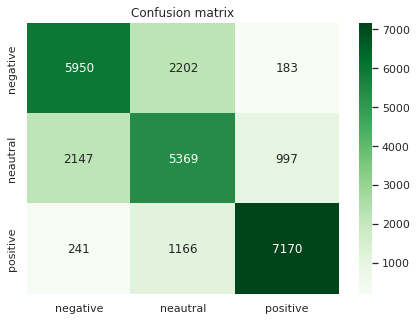

In [ ]:
clf = LogisticRegression(C=1e5) 
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       0.70      0.73      0.71      8335
           0       0.62      0.59      0.61      8513
           1       0.84      0.85      0.84      8577

    accuracy                           0.72     25425
   macro avg       0.72      0.72      0.72     25425
weighted avg       0.72      0.72      0.72     25425



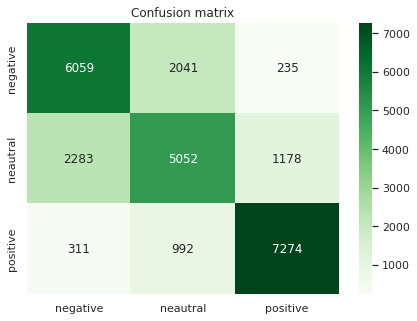

In [ ]:
clf = LinearSVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
report(y_test, y_pred)

Что-то стало даже хуже... Попробуем прогнать то же самое с лемматизированными текстами.

In [ ]:
df_ru['n-gramms_lemmatized'] = df_ru.lemmatized.map(lambda text: get_123grams(text))
df_ru.sample(3)

,preprocessed,sentiment,lemmatized,n-gramms,n-gramms_lemmatized
18209,ужасный продавец обманщик до последнего тянул ...,-1,ужасный продавец обманщик до последний тянуть ...,"[ужасный, продавец, обманщик, до, последнего, ...","[ужасный, продавец, обманщик, до, последний, т..."
77295,спасибо огромное за футболки заказывала двух ц...,1,спасибо огромный за футболка заказывать два цв...,"[спасибо, огромное, за, футболки, заказывала, ...","[спасибо, огромный, за, футболка, заказывать, ..."
12156,без карманов не точные как на фото,-1,без карман не точный как на фото,"[без, карманов, не, точные, как, на, фото, без...","[без, карман, не, точный, как, на, фото, без к..."


In [ ]:
model_ru = word2vec.Word2Vec(df_ru['n-gramms_lemmatized'], size=52, window=5, sg=1, workers=4, min_count=10)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_ru['n-gramms_lemmatized'].map(lambda tokens: average(model_ru, tokens)), df_ru.sentiment, train_size = 0.7, random_state=42)

In [ ]:
x_train, x_test = np.stack(x_train), np.stack(x_test)  

              precision    recall  f1-score   support

          -1       0.71      0.72      0.72      8335
           0       0.61      0.62      0.62      8513
           1       0.85      0.83      0.84      8577

    accuracy                           0.72     25425
   macro avg       0.72      0.72      0.72     25425
weighted avg       0.73      0.72      0.72     25425



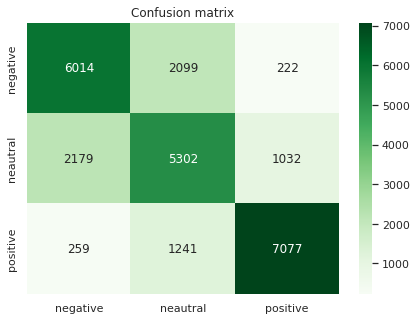

In [ ]:
clf = LogisticRegression(C=1e5) 
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
report(y_test, y_pred)

              precision    recall  f1-score   support

          -1       0.70      0.73      0.71      8335
           0       0.63      0.59      0.61      8513
           1       0.83      0.84      0.83      8577

    accuracy                           0.72     25425
   macro avg       0.72      0.72      0.72     25425
weighted avg       0.72      0.72      0.72     25425



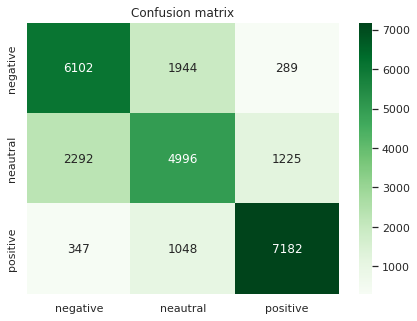

In [ ]:
clf = LinearSVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
report(y_test, y_pred)

Вывод первый: word2vec в данной задаче показывает себя не очень хорошо. Вывод второй: работа дата-саентиста выглядит как "ну я что-то ткнула, и оно вроде заработало". Поэтому можно и нужно пробовать различные методы предобработки, различные алгоритмы и эвристики, пока не получится приемлемый результат.

## Нейронки

У меня с нейронками беды, так что код практически полностью позаимствован у Чернышевой А.В.

In [ ]:
from torchvision import datasets, models, transforms
import os
import torch
from torch import nn
import torchvision as tv
import time
import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
X_TRAIN = torch.tensor(x_train.tolist())
Y_TRAIN = torch.tensor(y_train.map({-1: 0, 0: 1, 1: 2}).tolist())  # 0 is negative, 1 is neautral, 2 is positive

X_TEST = torch.tensor(x_test.tolist())
Y_TEST = torch.tensor(y_test.map({-1: 0, 0: 1, 1: 2}).tolist())  # 0 is negative, 1 is neautral, 2 is positive

In [ ]:
BATCH_SIZE = 256
num_epochs = 20
TRAIN_DATASET = TensorDataset(X_TRAIN, Y_TRAIN)
TEST_DATASET = TensorDataset(X_TEST, Y_TEST)
TRAIN = DataLoader(TRAIN_DATASET, BATCH_SIZE, shuffle=True)
TEST = DataLoader(TEST_DATASET, BATCH_SIZE, shuffle=True)

dev = torch.device("cpu")

In [ ]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train_model(net, train_iter, test_iter, trainer, num_epochs, accuracy=0, verbose=True):
    train_acc_history, test_acc_history = [], []

    loss = nn.CrossEntropyLoss(reduction='sum')
    best_model, best_acc = net, accuracy
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        net.train()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)

        train_acc_history.append(train_acc_sum / n)
        test_acc_history.append(test_acc)

        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
        best_acc = best_acc if test_acc < best_acc else test_acc
        best_model = best_model if test_acc < best_acc else net

    if verbose:
        return best_model, best_acc, train_acc_history, test_acc_history

    return best_model, best_acc

In [ ]:
model = torch.nn.Sequential(torch.nn.Flatten(),
                            torch.nn.Linear(52, 512), 

                            torch.nn.LeakyReLU(),
                            torch.nn.BatchNorm1d(512),
                            torch.nn.Linear(512, 256),

                            torch.nn.LeakyReLU(),
                            torch.nn.BatchNorm1d(256),
                            torch.nn.Linear(256, 3))
model = model.to(dev)

epoch 1, loss 0.6366, train acc 0.712, test acc 0.730
epoch 2, loss 0.6066, train acc 0.725, test acc 0.731
epoch 3, loss 0.5982, train acc 0.730, test acc 0.731
epoch 4, loss 0.5962, train acc 0.731, test acc 0.737
epoch 5, loss 0.5914, train acc 0.733, test acc 0.731
epoch 6, loss 0.5915, train acc 0.733, test acc 0.729
epoch 7, loss 0.5905, train acc 0.733, test acc 0.732
epoch 8, loss 0.5866, train acc 0.735, test acc 0.730
epoch 9, loss 0.5845, train acc 0.736, test acc 0.733
epoch 10, loss 0.5842, train acc 0.735, test acc 0.735
epoch 11, loss 0.5804, train acc 0.738, test acc 0.735
epoch 12, loss 0.5807, train acc 0.738, test acc 0.738
epoch 13, loss 0.5802, train acc 0.739, test acc 0.736
epoch 14, loss 0.5807, train acc 0.740, test acc 0.732
epoch 15, loss 0.5789, train acc 0.738, test acc 0.735
epoch 16, loss 0.5760, train acc 0.740, test acc 0.739
epoch 17, loss 0.5753, train acc 0.740, test acc 0.738
epoch 18, loss 0.5739, train acc 0.741, test acc 0.739
epoch 19, loss 0.57

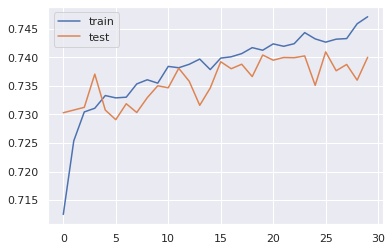

In [ ]:
lr, num_epochs = .01, 30
trainer = torch.optim.Adam(model.parameters(), lr=lr)
%time NET, ACCURACY, train_acc, test_acc = train_model(model, TRAIN, TEST, trainer, num_epochs)
print()
print('Best accuracy is', ACCURACY)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()

epoch 1, loss 0.5518, train acc 0.751, test acc 0.742
epoch 2, loss 0.5496, train acc 0.752, test acc 0.740
epoch 3, loss 0.5501, train acc 0.751, test acc 0.742
epoch 4, loss 0.5493, train acc 0.751, test acc 0.743
epoch 5, loss 0.5489, train acc 0.752, test acc 0.743
epoch 6, loss 0.5480, train acc 0.752, test acc 0.741
epoch 7, loss 0.5478, train acc 0.752, test acc 0.741
epoch 8, loss 0.5477, train acc 0.752, test acc 0.742
epoch 9, loss 0.5481, train acc 0.753, test acc 0.741
epoch 10, loss 0.5469, train acc 0.753, test acc 0.741
CPU times: user 43.6 s, sys: 199 ms, total: 43.8 s
Wall time: 43.8 s

Best accuracy is 0.743480825958702


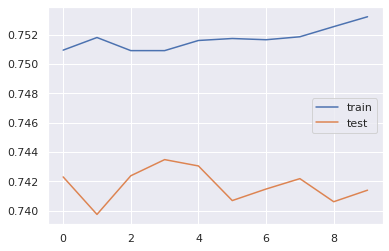

In [ ]:
lr, num_epochs = .0001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
%time NET, ACCURACY, train_acc, test_acc = train_model(model, TRAIN, TEST, trainer, num_epochs, accuracy=ACCURACY)
print()
print('Best accuracy is', ACCURACY)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()

In [ ]:
y_true = []
y_pred_2 = []
for X, y in TEST:
  X, y = X.to(dev), y.to(dev)
  y_pred_1 = NET(X)
  y_true.extend(y)
  y_pred_2.extend(y_pred_1.argmax(dim=1))

In [ ]:
y_true = [i.item() for i in y_true]
y_pred_2 = [i.item() for i in y_pred_2]

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      8335
           1       0.62      0.68      0.65      8513
           2       0.88      0.83      0.85      8577

    accuracy                           0.74     25425
   macro avg       0.75      0.74      0.74     25425
weighted avg       0.75      0.74      0.74     25425



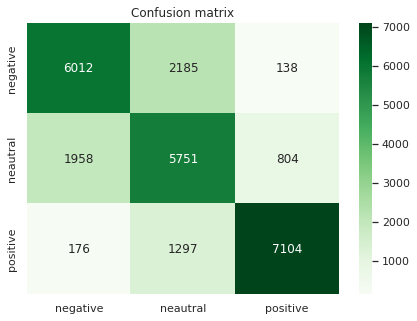

In [ ]:
report(y_true, y_pred_2)

Нейронки работают лучше, чем другие алгоритмы на word2vec, но TF-IDF и LinearSCV показали самый лучший результат. 